Начнем с импорта нужных нам библиотек.

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder



Далее прочитаем данные таблицы из файла.

In [9]:
data_xlsx = pd.read_excel('first_practice_dataframe.xlsx')
# выбираем столбцы, соответствующие варианту
data = data_xlsx[['cat16_city', 'cat11_nationality', 'num1_5', 'num2_5', 'num3_5']]
data

,cat16_city,cat11_nationality,num1_5,num2_5,num3_5
0,moscow,german,200.404132,374.849841,537.784087
1,St. Petersburg,German,236.691176,757.925894,525.436417
2,St. Petersburg,german,-26.114921,556.885394,572.672166
3,Moscow,German,-82.764817,915.702660,570.468156
4,Chelyabinsk,german,389.350889,595.813259,457.299999
...,...,...,...,...,...
995,moscow,French,1120.816296,652.583299,-
996,Novosibirsk,German,-293.568986,334.198157,455.503513
997,novosibirsk,German,402.936795,-36.892527,509.947684
998,novosibirsk,German,-157.655030,165.774970,455.301733


Выполним первое задание и построим визуальное представление каждого признака

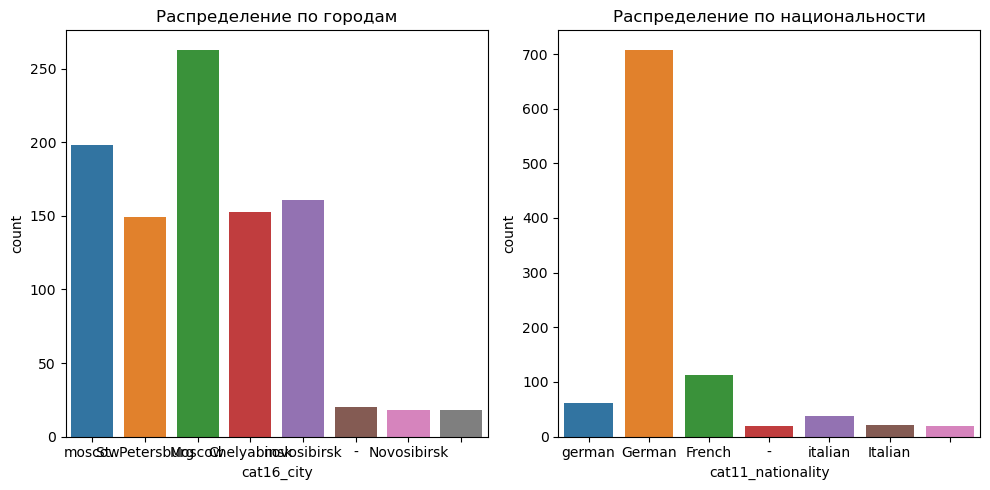

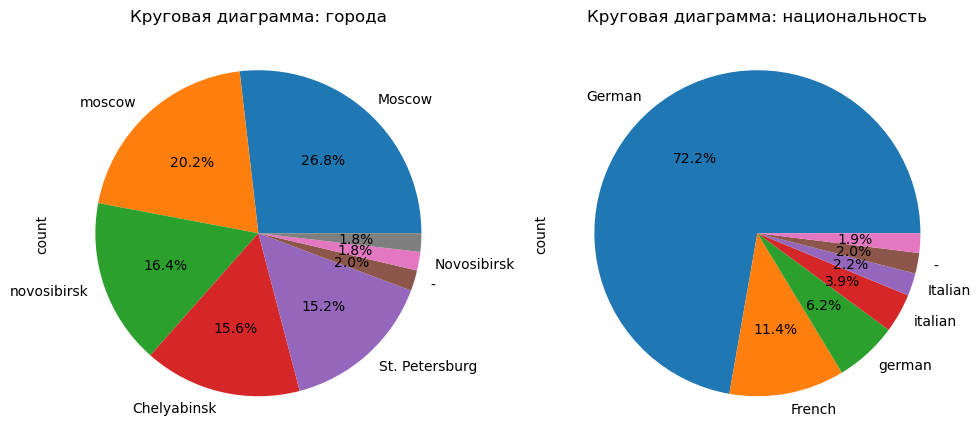

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='cat16_city', data=data)
plt.title('Распределение по городам')
plt.subplot(1, 2, 2)
sns.countplot(x='cat11_nationality', data=data)
plt.title('Распределение по национальности')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data['cat16_city'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Круговая диаграмма: города')
plt.subplot(1, 2, 2)
data['cat11_nationality'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Круговая диаграмма: национальность')
plt.tight_layout()
plt.show()

c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


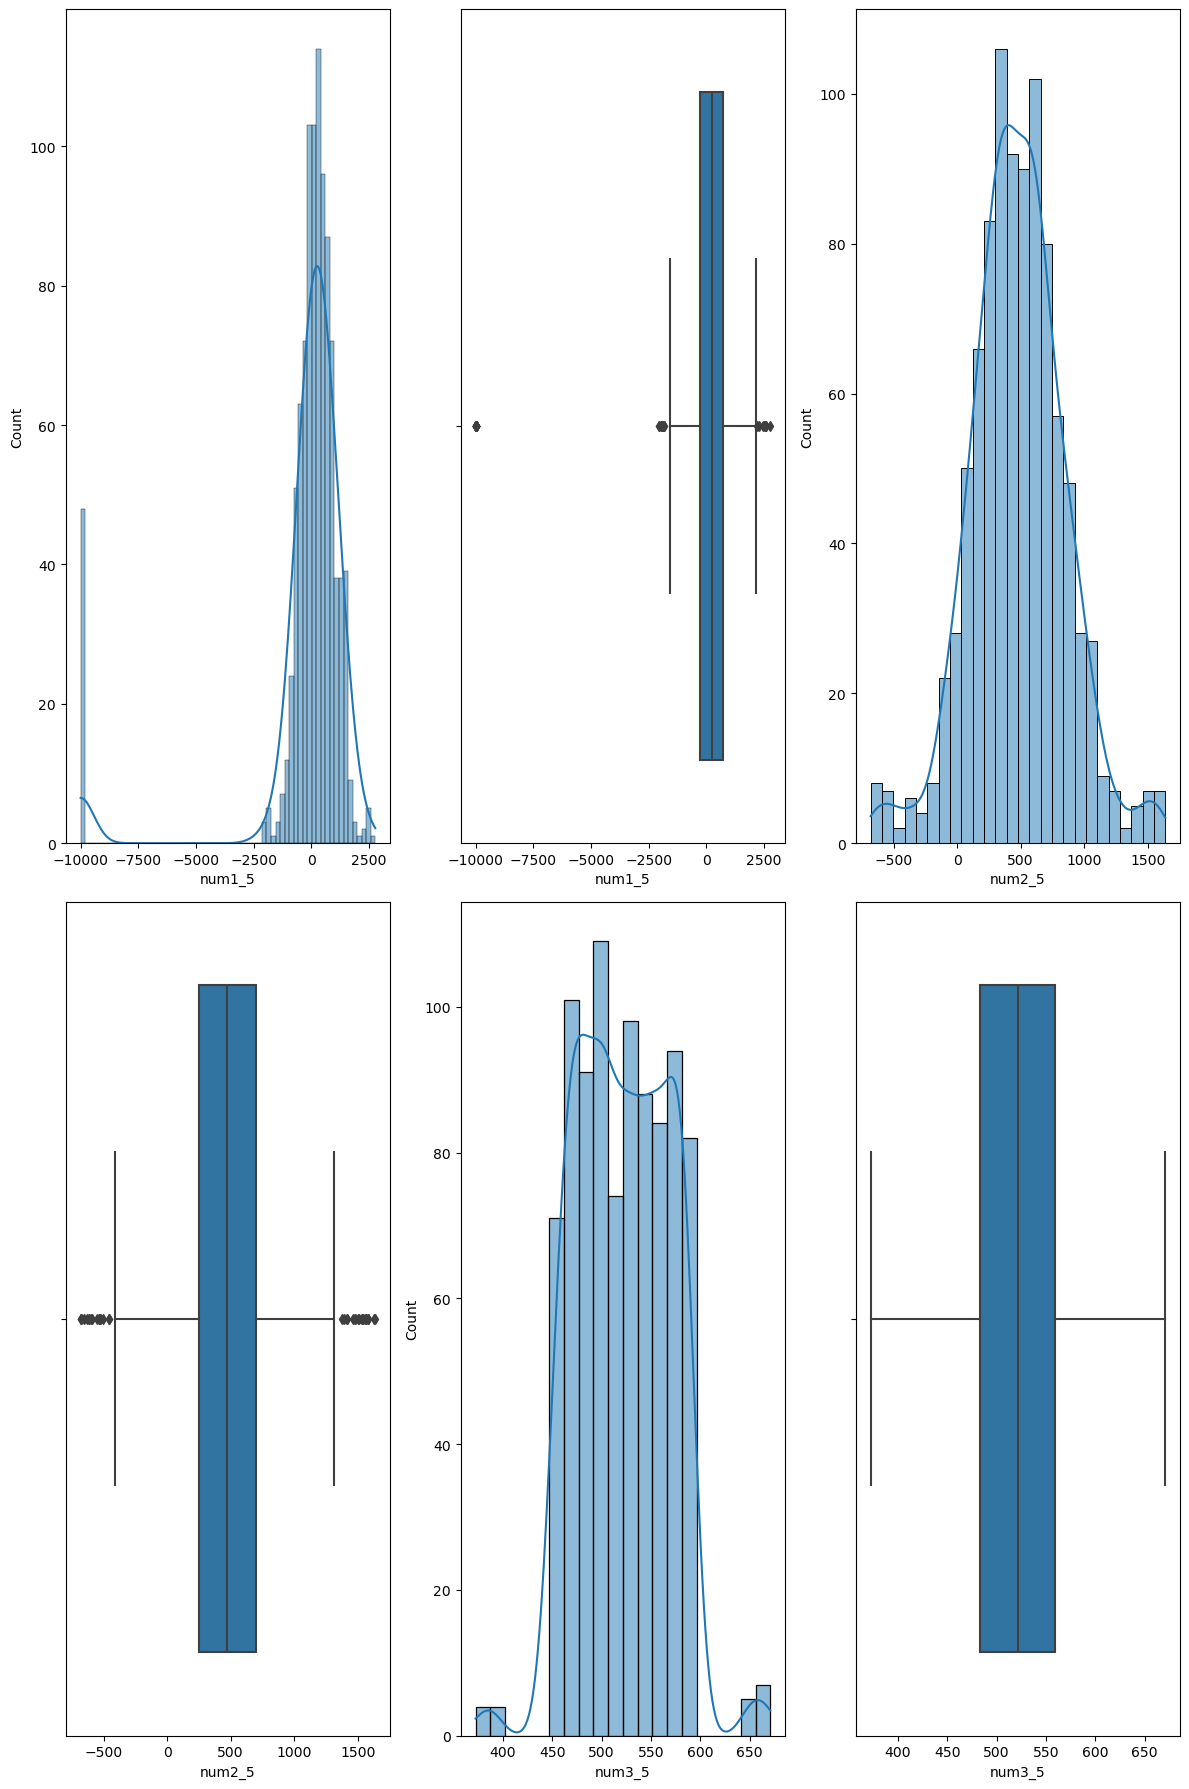

In [11]:
data_copy = data.copy(deep=True)
data_copy['num3_5'] = data_copy['num3_5'].replace([r'^\s+$', r'-'], np.nan, regex=True) 


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 18))
columns = ['num1_5', 'num2_5', 'num3_5']
axes_iterator = iter(axes.flatten())
 
for column in columns:
    sns.histplot(data=data_copy, x=column, kde=True, ax=next(axes_iterator))
    sns.boxplot(x=data_copy[column], ax=next(axes_iterator))

plt.tight_layout()
plt.show()

Теперь проведем проверку правдоподобности исходных данных

In [12]:
data = data.copy(deep=True)
data['cat16_city'] = data['cat16_city'].str.upper()
data['cat11_nationality'] = data['cat11_nationality'].str.upper()
# Замена некорректных значений в столбцах 'cat16_city' и 'cat11_nationality' на NaN
for col in ['cat16_city', 'cat11_nationality']:
    data_filter = ~data[col].astype(str).str.isalpha() # 1 если есть буквенные символы, 0 если хотя бы 1 не буквенный
    data.loc[data_filter, col] = np.nan

# Замена значений -9999 на NaN в столбцах 'num1_5', 'num2_5', 'num3_5'
data[['num1_5', 'num2_5', 'num3_5']] = data[['num1_5', 'num2_5', 'num3_5']].replace(-9999, np.nan)

# Замена пустых строк и символов '-' на NaN в столбцах 'num1_5', 'num2_5', 'num3_5'
for col in ['num1_5', 'num2_5', 'num3_5']:
    data[col] = data[col].replace([r'^\s+$', r'-'], np.nan, regex=True)

data

,cat16_city,cat11_nationality,num1_5,num2_5,num3_5
0,MOSCOW,GERMAN,200.404132,374.849841,537.784087
1,NaN,GERMAN,236.691176,757.925894,525.436417
2,NaN,GERMAN,-26.114921,556.885394,572.672166
3,MOSCOW,GERMAN,-82.764817,915.702660,570.468156
4,CHELYABINSK,GERMAN,389.350889,595.813259,457.299999
...,...,...,...,...,...
995,MOSCOW,FRENCH,1120.816296,652.583299,NaN
996,NOVOSIBIRSK,GERMAN,-293.568986,334.198157,455.503513
997,NOVOSIBIRSK,GERMAN,402.936795,-36.892527,509.947684
998,NOVOSIBIRSK,GERMAN,-157.655030,165.774970,455.301733


Поиск аномальных значений

In [13]:
# Определяем порог для сигм
threshold = 3

# Применяем метод сигм
c, low, upp = sc.stats.sigmaclip(data['num1_5'].dropna(), threshold, threshold)

data_cleaned_sigma = data[(data['num1_5'] >= low) & (data['num1_5'] <= upp)]



# Метод квартилей
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

data_cleaned_iqr = remove_outliers_iqr(data, 'num1_5')


print('sigma\n', data_cleaned_sigma)
print('IQR\n', data_cleaned_iqr)

sigma
       cat16_city cat11_nationality       num1_5      num2_5      num3_5
0         MOSCOW            GERMAN   200.404132  374.849841  537.784087
1            NaN            GERMAN   236.691176  757.925894  525.436417
2            NaN            GERMAN   -26.114921  556.885394  572.672166
3         MOSCOW            GERMAN   -82.764817  915.702660  570.468156
4    CHELYABINSK            GERMAN   389.350889  595.813259  457.299999
..           ...               ...          ...         ...         ...
995       MOSCOW            FRENCH  1120.816296  652.583299         NaN
996  NOVOSIBIRSK            GERMAN  -293.568986  334.198157  455.503513
997  NOVOSIBIRSK            GERMAN   402.936795  -36.892527  509.947684
998  NOVOSIBIRSK            GERMAN  -157.655030  165.774970  455.301733
999       MOSCOW            GERMAN   977.483615  655.035162  510.341900

[937 rows x 5 columns]
IQR
       cat16_city cat11_nationality       num1_5      num2_5      num3_5
0         MOSCOW            

Поиск и восстановление пропущенных значений

In [14]:
data_cleaned_sigma.reset_index(drop=True, inplace=True)

data = data_cleaned_sigma

# Поиск пропущенных значений
missing_data = data.isnull().sum()
print("Статистика по пропущенным значениям\n", missing_data)
ohe = OneHotEncoder(drop='first', sparse_output=False)
 
encoded_data = pd.DataFrame(ohe.fit_transform(data[['cat16_city']]))
encoded_data.columns = ohe.get_feature_names_out()
 
data_onehot = data.join(encoded_data)
data_onehot.drop('cat16_city', axis = 1, inplace = True)
encoded_values = encoded_data.to_numpy()
data_onehot['cat16_city'] = list(map(lambda x: np.argmax(x), encoded_values))
data_onehot.drop(encoded_data.columns, axis=1, inplace=True)

print(data_onehot)
data = data_onehot

# Восстановление пропущенных значений
# K ближайших соседей для первого признака
imputer = KNNImputer(n_neighbors=5)
features = ['cat16_city', 'num1_5']
data['cat16_city'] = imputer.fit_transform(data[features])


# Замена пропущенных значений самым популярным значением для второго признака
data['cat11_nationality'] = data['cat11_nationality'].fillna(data['cat11_nationality'].mode()[0])

# Замена пропущенных значений средним значением для третьего признака
data['num1_5'] = data['num1_5'].fillna(data['num1_5'].mean())

# Замена пропущенных значений медианой для четвертого признака
data['num2_5'] = data['num2_5'].fillna(data['num2_5'].median())

# K ближайших соседей для пятого признака
data['num3_5'] = imputer.fit_transform(data[['num3_5']])

data


Статистика по пропущенным значениям
 cat16_city           195
cat11_nationality     53
num1_5                 0
num2_5                48
num3_5                78
dtype: int64
    cat11_nationality       num1_5      num2_5      num3_5  cat16_city
0              GERMAN   200.404132  374.849841  537.784087           0
1              GERMAN   236.691176  757.925894  525.436417           2
2              GERMAN   -26.114921  556.885394  572.672166           2
3              GERMAN   -82.764817  915.702660  570.468156           0
4              GERMAN   389.350889  595.813259  457.299999           0
..                ...          ...         ...         ...         ...
932            FRENCH  1120.816296  652.583299         NaN           0
933            GERMAN  -293.568986  334.198157  455.503513           1
934            GERMAN   402.936795  -36.892527  509.947684           1
935            GERMAN  -157.655030  165.774970  455.301733           1
936            GERMAN   977.483615  655.0351

,cat11_nationality,num1_5,num2_5,num3_5,cat16_city
0,GERMAN,200.404132,374.849841,537.784087,0.0
1,GERMAN,236.691176,757.925894,525.436417,2.0
2,GERMAN,-26.114921,556.885394,572.672166,2.0
3,GERMAN,-82.764817,915.702660,570.468156,0.0
4,GERMAN,389.350889,595.813259,457.299999,0.0
...,...,...,...,...,...
932,FRENCH,1120.816296,652.583299,521.269429,0.0
933,GERMAN,-293.568986,334.198157,455.503513,1.0
934,GERMAN,402.936795,-36.892527,509.947684,1.0
935,GERMAN,-157.655030,165.774970,455.301733,1.0


Преобразование данных

In [15]:

# Стандартизация и нормализация числовых признаков
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
label_encoder = LabelEncoder()
data[['num1_5', 'num2_5', 'num3_5']] = scaler.fit_transform(data[['num1_5', 'num2_5', 'num3_5']])
data[['num1_5', 'num2_5', 'num3_5']] = minmax_scaler.fit_transform(data[['num1_5', 'num2_5', 'num3_5']])

# One-hot encoding для категориального признака cat16_city
#cat16_encoded = one_hot_encoder.fit_transform(data[['cat16_city']]).toarray()

# Label encoding для категориального признака cat11_nationality
data['cat11_nationality'] = label_encoder.fit_transform(data['cat11_nationality'])

data

,cat11_nationality,num1_5,num2_5,num3_5,cat16_city
0,1,0.467390,0.455338,0.554085,0.0
1,1,0.477063,0.620590,0.512769,2.0
2,1,0.407004,0.533864,0.670823,2.0
3,1,0.391902,0.688651,0.663448,0.0
4,1,0.517760,0.550657,0.284778,0.0
...,...,...,...,...,...
932,0,0.712756,0.575147,0.498825,0.0
933,1,0.335705,0.437801,0.278767,1.0
934,1,0.521382,0.277720,0.460942,1.0
935,1,0.371937,0.365147,0.278092,1.0


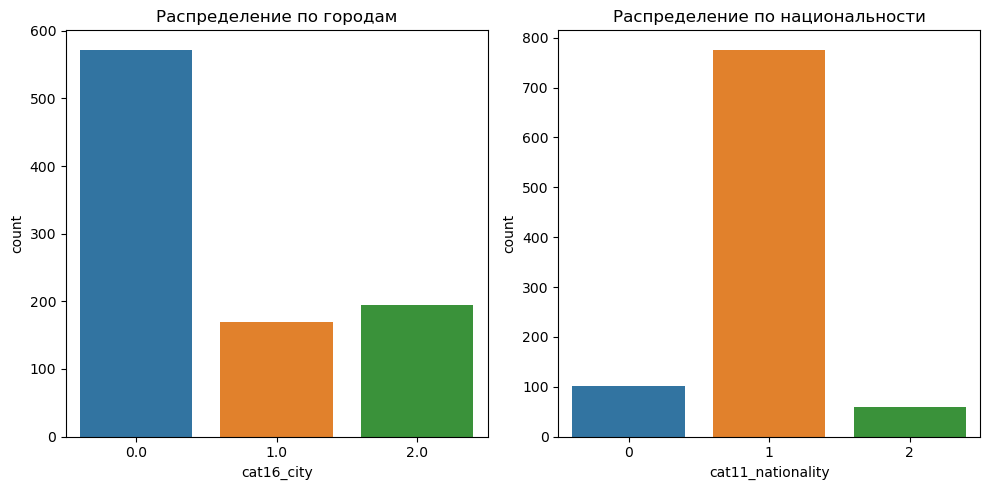

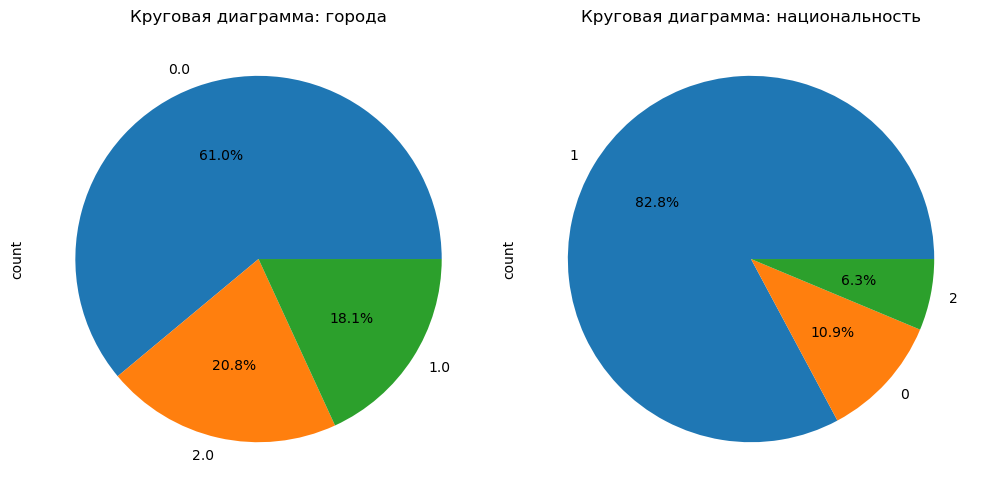

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='cat16_city', data=data)
plt.title('Распределение по городам')
plt.subplot(1, 2, 2)
sns.countplot(x='cat11_nationality', data=data)
plt.title('Распределение по национальности')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data['cat16_city'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Круговая диаграмма: города')
plt.subplot(1, 2, 2)
data['cat11_nationality'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Круговая диаграмма: национальность')
plt.tight_layout()
plt.show()